# First attempts at visualization

The purpose of this notebook is to evaluate different visualization methods on different tasks:

1. Triangle vs Circle
2. Counting spots
3. Counting die numbers

We first look at the dataset, followed by training networks, and finally looking at their visualizations.

## Triangle vs Circle

### The dataset

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import vizlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import lasagne
import nolearn.lasagne
from lasagne.layers import *
import theano
import theano.tensor as T
from sklearn.metrics import confusion_matrix
import nolearn.lasagne.visualize

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

Using gpu device 0: Tesla K40c (CNMeM is disabled, CuDNN not available)
/home/wojtek/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


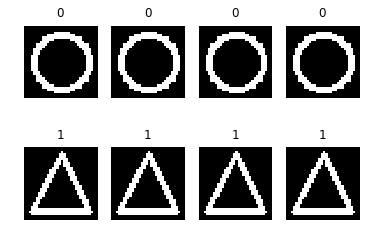

In [3]:
ds = vizlib.data.triangle_and_circle().show_sample()

In [4]:
pd.value_counts(ds.y)

1    50
0    50
dtype: int64

In [5]:
# Here we have 100 samples total. For each category are images are identical.
# I just duplicated to allow reuse of code
# ---just 2 images gives problems with splitting the dataset into train and test.
# All datasets are z-standardized by default, 
# that is to say, each individual image is transformed to have 0 mean and 1 std:
print(set(ds.X.mean(axis=(1,2,3))), set(ds.X.std(axis=(1,2,3))))

(set([-1.3877787807814457e-17, -8.1532003370909933e-17]), set([1.0, 0.99999999999999989]))


### Training a network

In [33]:
# One can image such a thing can be easily learned using a shallow network.
# For example, with a single filter that just 'remembers' the entire input image.
np.random.seed(52)
input_layer = InputLayer((None, 1, 32, 32))
conv_layer = Conv2DLayer(input_layer, num_filters=1, filter_size=(32,32), pad=0)
dense_layer = DenseLayer(conv_layer, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)
# FIXME: the learning_rate needs to be 1, and if I 'overtrain', 
# the network starts to underperform on the training set.
# - I tried using nolearn.lasagne.NeuralNet instead of my GpuNet implementation,
#   but the results are the same.
nn = nolearn.lasagne.NeuralNet(dense_layer, update_learning_rate=1, update_momentum=0.9, verbose=0)
nn.fit(ds.X, ds.y, epochs=100)
confusion_matrix(ds.y, nn.predict(ds.X)), (ds.y == nn.predict(ds.X)).mean()

(array([[50,  0],
        [ 0, 50]]), 1.0)

In [35]:
set([tuple(x) for x in nn.predict_proba(ds.X)])
# The predictions are very close together...
# Training longer does not help, in fact, the results get worse!

{(0.49999999999997036, 0.50000000000002975),
 (0.50000000000005529, 0.49999999999994466)}

### Visualizing a Network

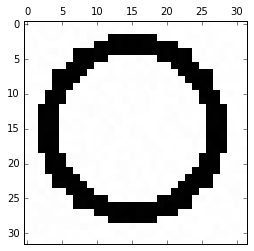

In [36]:
# Looking simply at the filter of the conv_layer already gives us
# a reasonable idea of what is going in this case
plt.matshow(conv_layer.W.get_value().squeeze());

#### Activation Maximization

We may also look at inputs that maximize the activation of certain neurons.

Here we use the activation to mean the sum of the inputs, rather than the sum of the inputs w/ a non-linearity applied on it (which would be the output of said neuron).

In this case I found that gradient descent does not reach an optimum if no additional constraints are applied. That is to say, if there are no contraints on the input image, we can always do (not strictly) better simply by multiplying the pixel intensities of the input image.

In [37]:
X_init = np.random.randn(1, 1, 32, 32).astype(theano.config.floatX)
X_init -= X_init.mean()
X_init /= X_init.std()
print(X_init.mean(), X_init.std())

(-3.1225022567582528e-17, 1.0)


In [38]:
max_norm = lasagne.utils.compute_norms(X_init).max()
scores_and_maximizers = vizlib.activation_maximization.maximize_scores(dense_layer, X_init, number_of_iterations=10000, max_norm=max_norm)
scores, maximizers = zip(*scores_and_maximizers)

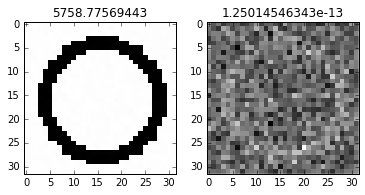

In [39]:
for i, (s, m) in enumerate(scores_and_maximizers, 1):
    plt.subplot(1, len(scores_and_maximizers), i)
    plt.imshow(m.squeeze())
    plt.title(s)
# Apparently it is enough to learn the concept of a circle.

In [48]:
# Apparently it is enough to simply learn the concept of [not] a circle.
triangle = ds.X[ds.y == 0][0:1]
circle = ds.X[ds.y == 1][0:1]

triangle_maximizer = maximizers[0]
circle_maximizer = maximizers[1]

print(nn.predict(triangle), nn.predict_proba(triangle))
print(nn.predict(circle), nn.predict_proba(circle))

print(nn.predict(triangle_maximizer), nn.predict_proba(triangle_maximizer))
print(nn.predict(circle_maximizer), nn.predict_proba(circle_maximizer))
# We see that we can just barely distinguish a circle from a triangle.
# The 0.5 are rounded, in practice they allow us to differentiate.

(array([0]), array([[ 0.5,  0.5]]))
(array([1]), array([[ 0.5,  0.5]]))
(array([0]), array([[ 1.,  0.]]))
(array([1]), array([[ 0.5,  0.5]]))


#### Class Saliency Maps

The key idea behind a Class Saliency Map is that we assign to each pixel an importance value.

Two methods to determine this importance are suggested in the literature.

The first is to occlude or cover certain parts of the input image, and then observe the effect on the class score. If occluding a certain part of the image leads to a big difference in class score, that part of the image is assumed important.

Another approach is to approximate the class score function using Taylor Series Expansion. The first term in this expansion is the gradient of the class score evaluated at the input image, multiplied by the input image. We can thus assume the magnitude of the gradient to determine the importance of each input pixel.

##### Image Occlusion

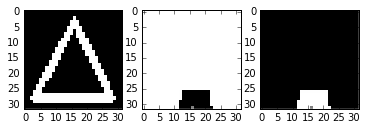

In [49]:



occ00 = vizlib.class_saliency_map.occlusion(ds.X[0][None,:,:,:], dense_layer, 0)
occ01 = vizlib.class_saliency_map.occlusion(ds.X[0][None,:,:,:], dense_layer, 1)
plt.subplot(1,3,1)
plt.imshow(ds.X[0].squeeze())
plt.subplot(1,3,2)
plt.imshow(occ00)
plt.subplot(1,3,3)
plt.imshow(occ01);

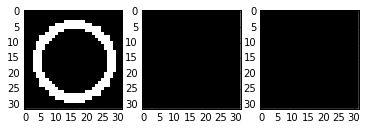

In [50]:
occ00 = vizlib.class_saliency_map.occlusion(ds.X[2][None,:,:,:], dense_layer, 0)
occ01 = vizlib.class_saliency_map.occlusion(ds.X[2][None,:,:,:], dense_layer, 1)
plt.subplot(1,3,1)
plt.imshow(ds.X[2].squeeze())
plt.subplot(1,3,2)
plt.imshow(occ00)
plt.subplot(1,3,3)
plt.imshow(occ01);

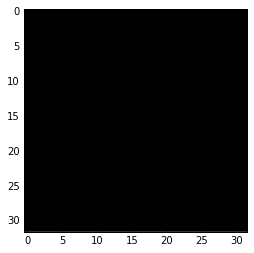

In [51]:
plt.imshow(vizlib.class_saliency_map.taylor_expansion(ds.X[2][None,:,:,:], dense_layer, 0))